In [211]:
import xml.etree.ElementTree as ET
import itertools
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

data = []
target = []
test_data = []
test_target = []
categories = ["current", "past", "non", "unknown"]

In [212]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    sns.heatmap(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [213]:
def parsetrain(filename):
    tree = ET.parse(filename)
    #this filename can be changed to accommodate different smoker files
    root = tree.getroot()

    for element in root.findall('RECORD'):
        text = str(element.find('TEXT').text)[50:]
        data.append(text)
        s= str(element.find("SMOKING").attrib['STATUS'])
        if "UNK" in s:
            target.append(4)
        elif "NON" in s:
            target.append(3)
        elif "PAST" in s:
            target.append(2)
        else:
            target.append(1)
            
def parsetest(filename):
    tree = ET.parse(filename)
    #this filename can be changed to accommodate different smoker files
    root = tree.getroot()

    for element in root.findall('RECORD'):
        text = str(element.find('TEXT').text)[50:]
        test_data.append(text)
        s= str(element.find("SMOKING").attrib['STATUS'])
        if "UNK" in s:
            test_target.append(4)
        elif "NON" in s:
            test_target.append(3)
        elif "PAST" in s:
            test_target.append(2)
        else:
            test_target.append(1)

In [214]:
parsetrain('smokers_surrogate_train_all_version2.xml')
parsetest('smokers_surrogate_test_all_groundtruth_version2.xml')

In [215]:
#TFIDF feature extraction - will be used for the rest of the tests
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, target)

0.605769230769
Normalized confusion matrix
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


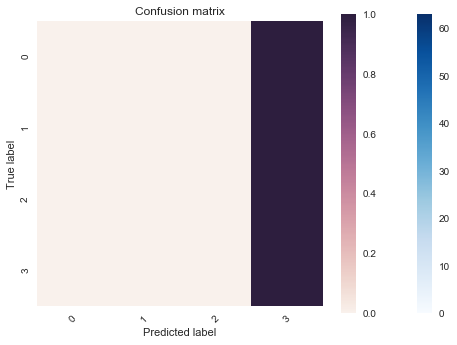

In [216]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
_ = text_clf.fit(data, target)
predicted = text_clf.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)

0.625
Normalized confusion matrix
[[ 0.          0.          0.07142857  0.92857143]
 [ 0.          0.          0.18181818  0.81818182]
 [ 0.          0.          0.1875      0.8125    ]
 [ 0.          0.          0.01587302  0.98412698]]


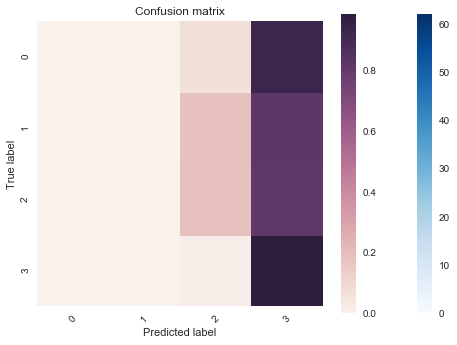

In [217]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()), 
                     ('clf', SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-3, n_iter=5, random_state=42)),
])
_ = text_clf_svm.fit(data, target)
predicted = text_clf_svm.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)

0.615384615385
Normalized confusion matrix
[[ 0.          0.14285714  0.21428571  0.64285714]
 [ 0.09090909  0.          0.27272727  0.63636364]
 [ 0.0625      0.          0.1875      0.75      ]
 [ 0.          0.          0.03174603  0.96825397]]


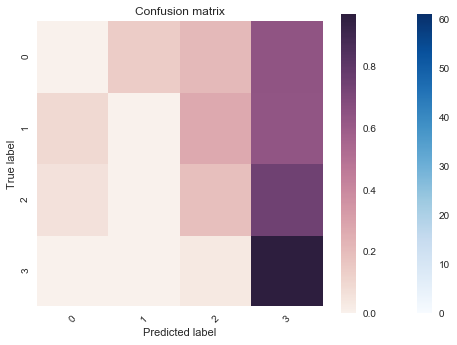

In [218]:
text_clf_rdf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', RandomForestClassifier(n_estimators=10, 
                                                        criterion = "entropy")),
])
_ = text_clf_rdf.fit(data, target)
predicted = text_clf_rdf.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)

0.740384615385
Normalized confusion matrix
[[ 0.5         0.35714286  0.07142857  0.07142857]
 [ 0.18181818  0.45454545  0.27272727  0.09090909]
 [ 0.0625      0.125       0.625       0.1875    ]
 [ 0.04761905  0.03174603  0.04761905  0.87301587]]


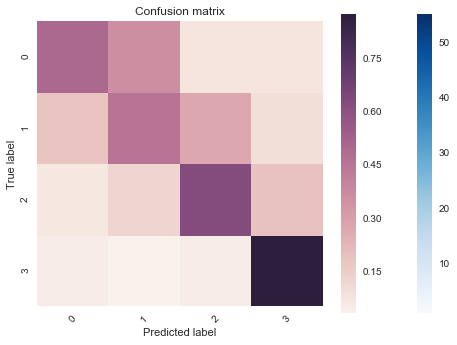

In [219]:
text_clf_dct = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', tree.DecisionTreeClassifier()),
])
_ = text_clf_dct.fit(data, target)
predicted = text_clf_dct.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
plt.show()
#print(predicted)

0.605769230769
Normalized confusion matrix
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


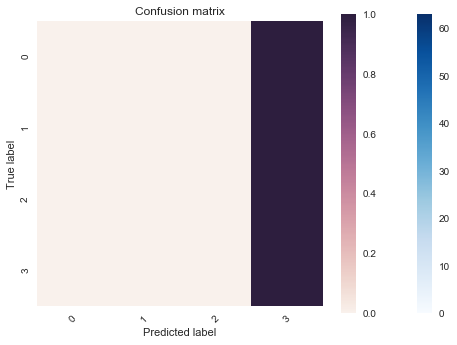

In [220]:
text_clf_svc = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', SVC()),
])
_ = text_clf_svc.fit(data, target)
predicted = text_clf_svc.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
plt.show()

In [221]:
#conclusion - tf-idf feature extraction doesn't really work - move back to n-gram